![CleanShot 2025-01-17 at 11.42.39@2x.png](<attachment:CleanShot 2025-01-17 at 11.42.39@2x.png>)
from https://arxiv.org/pdf/1511.06434
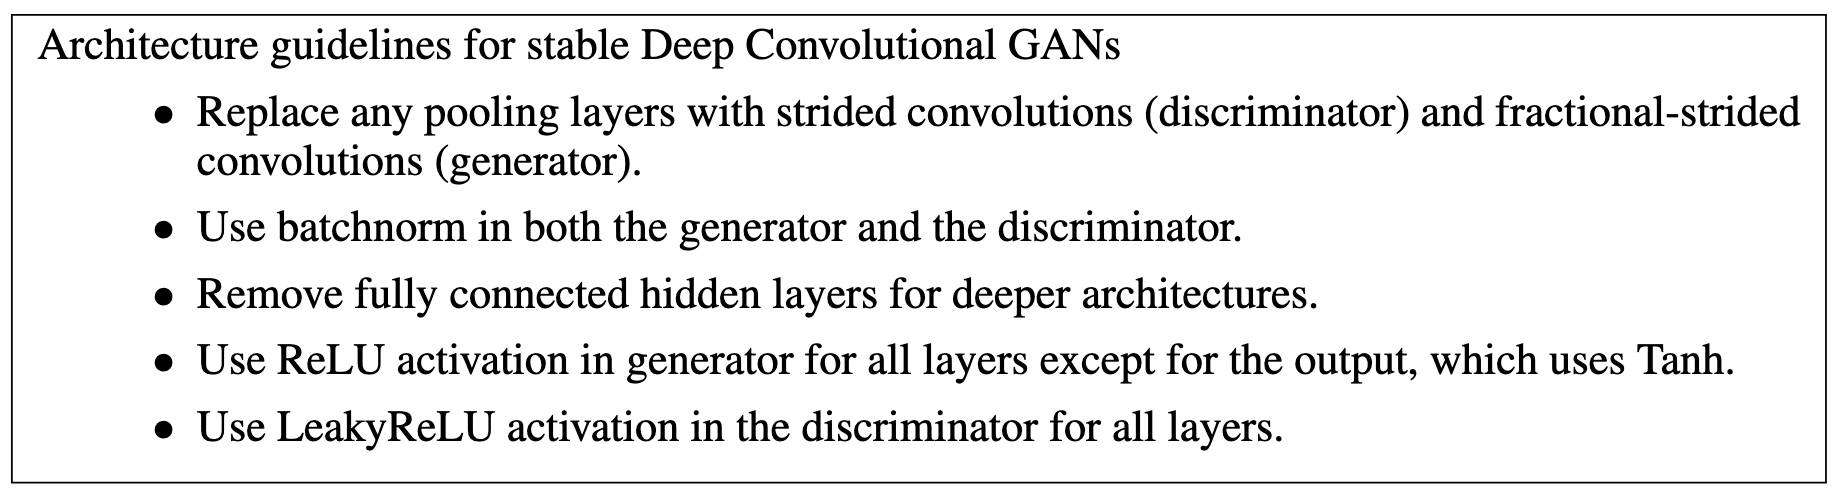

In [2]:
import equinox as eqx
import equinox.nn as nn
import jax
import jax.numpy as jnp

RELU_SLOPE = 0.2


class Generator(eqx.Module):
    layers: list
    last_layer: eqx.nn.ConvTranspose2d

    def __init__(self, hidden: int = 32, key=None):
        k0, k1, k2, k3, k4 = jax.random.split(key, 5)

        self.layers = [
            nn.ConvTranspose2d(
                64, 4 * hidden, kernel_size=3, stride=2, padding="VALID", key=k0
            ),
            nn.ConvTranspose2d(
                4 * hidden, 2 * hidden, kernel_size=4, stride=2, key=k1
            ),
            nn.ConvTranspose2d(2 * hidden, hidden, kernel_size=3, stride=2, key=k2),
            nn.ConvTranspose2d(
                hidden, hidden, kernel_size=4, stride=2, padding=3, key=k3
            ),
        ]

        self.last_layer = nn.ConvTranspose2d(hidden, 1, kernel_size=1, stride=1, padding=1, key=k4)

    @jax.jit
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            x = jax.nn.leaky_relu(x, RELU_SLOPE) * jnp.sqrt(2)
        x = self.last_layer(x)
        return jax.nn.tanh(x)

In [3]:
class Tests:

    def __init__(self):
        self.key = jax.random.PRNGKey(0)
        
        for func_name in dir(self):
            if callable(getattr(self, func_name)) and ("test_" in func_name or "_test" in func_name):
                self.key, k = jax.random.split(self.key)
                func = getattr(self, func_name)
                func(k)

    def test_gan_size(self, key):
        model = Generator(key=key)
        random_input = jax.random.normal(key, shape=(256, 64, 1, 1))
        output = jax.vmap(model)(random_input)
        assert output.shape == (256, 1, 28, 28), f"Expected output shape (N, 1, 28, 28), got {output.shape}"

    # def test_disc_size(self, key):
    #     model = Discriminator(key=key)
    #     random_input = jax.random.normal(key, shape=(256, 1, 32, 32))
    #     output = jax.vmap(model)(random_input)
    #     assert output.shape == (256, 1), f"Expected output shape (N, 1), got {output.shape}"
        

Tests()


In [4]:
class Discriminator(eqx.Module):
    layers: list

    def __init__(self, hidden: int = 32, key=None):
        k0, k1, k2, k3 = jax.random.split(key, 4)

        self.layers = [
            nn.Conv2d(1, hidden, kernel_size=3, stride=2, padding=1, key=k0),
            nn.Conv2d(hidden, 2 * hidden, kernel_size=3, stride=2, padding=1, key=k1),
            nn.Conv2d(2 * hidden, 4 * hidden, kernel_size=3, stride=2, padding=1, key=k2),
            nn.Conv2d(4 * hidden, 1, kernel_size=4, padding=0, key=k3),
        ]

    @jax.jit
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            x = jax.nn.leaky_relu(x, RELU_SLOPE)
        return jnp.reshape(x, (-1,))

In [5]:
@jax.jit
@eqx.filter_value_and_grad
def calc_gan_loss(model, disc, x, y):
    output = model(x)

    return -jnp.mean(jax.nn.log_sigmoid(disc(output)))

@jax.jit
@eqx.filter_value_and_grad
def calc_disc_loss(disc, fake, real):
    fake_pred = disc(fake)
    real_pred = disc(real)

    return -(jnp.mean(jax.nn.log_sigmoid(real_pred))+jnp.mean(jax.nn.log_sigmoid(1-fake_pred))) / 2

def make_step(model, disc, gan_optim, disc_optim, gan_opt_state, disc_opt_state, x, y):
    gan_loss, grads = jax.vmap(calc_gan_loss, in_axes=(None, None, 0, 0), out_axes=(0, 0))(model, disc, x, y)
    gan_loss, grads = jnp.mean(gan_loss), jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    updates, gan_opt_state = gan_optim.update(grads, gan_opt_state, model)
    model = eqx.apply_updates(model, updates)

    output = jax.vmap(model)(x)

    disc_loss, grads = jax.vmap(calc_disc_loss, in_axes=(None, 0, 0), out_axes=(0, 0))(disc, output, y)
    disc_loss, grads = jnp.mean(disc_loss), jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    updates, disc_opt_state = disc_optim.update(grads, disc_opt_state, disc)
    disc = eqx.apply_updates(disc, updates)

    return model, disc, gan_opt_state, disc_opt_state, gan_loss, disc_loss, output


In [12]:

import datasets
import optax
import matplotlib.pyplot as plt
from IPython.display import clear_output

print(jax.devices())
data = datasets.load_dataset("ylecun/mnist").with_format("jax")

# data = data.filter(lambda x: x["label"] == 1)
train_set, test_set = data["train"], data["test"]
train_set = jnp.expand_dims(train_set["image"]/255, 1)
test_set = jnp.expand_dims(test_set["image"]/255, 1)


[CudaDevice(id=0)]


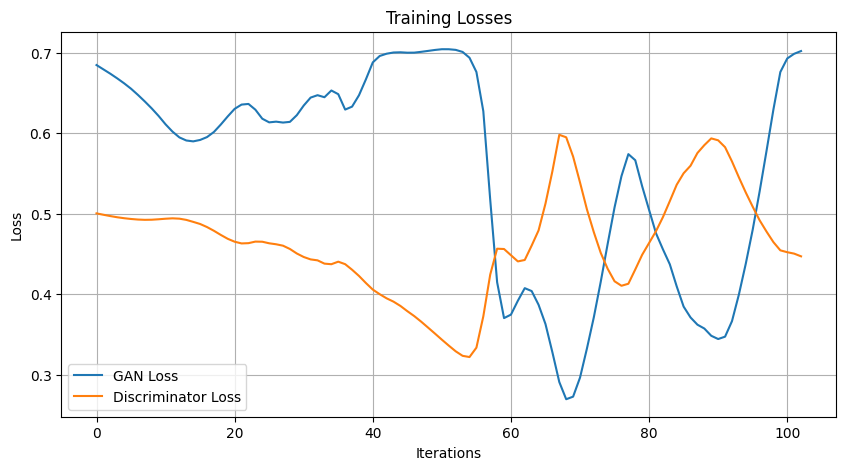

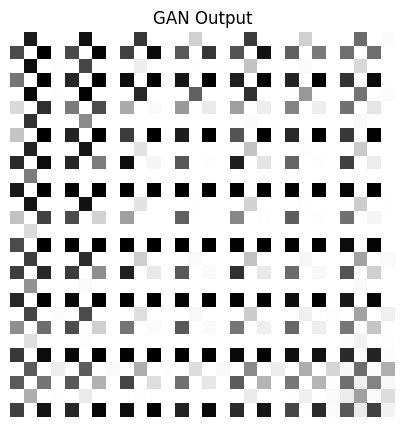

In [15]:

# # import cProfile
# # import pstats  
# def train():

key = jax.random.PRNGKey(0)

k1, k2 = jax.random.split(key)

generator = Generator(key=k1)
discriminator = Discriminator(key=k2)


gan_optim = optax.adamw(1e-3)
disc_optim = optax.adamw(1e-4)

gan_opt_state = gan_optim.init(generator)
disc_opt_state = disc_optim.init(discriminator)

batch_size = 4096
epochs = 100

gan_losses = []
disc_losses = []
            

for step in range(epochs * train_set.shape[0] // batch_size):
    key, k = jax.random.split(key)
    x, y = jax.random.normal(key=k, shape=(batch_size, 64, 1, 1)), jax.random.choice(k, train_set, (batch_size,))
    # print(y.shape)
    # # print(y.device)
    # print(generator.shard)
    (
        generator,
        discriminator,
        gan_opt_state,
        disc_opt_state,
        gan_loss,
        disc_loss,
        gan_output
    ) = make_step(
        generator,
        discriminator,
        gan_optim,
        disc_optim,
        gan_opt_state,
        disc_opt_state,
        x,
        y,
    )
    
    # # Log loss
    gan_losses.append(gan_loss)
    disc_losses.append(disc_loss)

    clear_output(wait=True)

    plt.figure(figsize=(10, 5))
    plt.plot(gan_losses, label="GAN Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training Losses")
    plt.legend()
    plt.grid()
    plt.show()

    # Create the second figure for the GAN output
    plt.figure(figsize=(5, 5))
    plt.imshow(gan_output[0, 0], cmap="binary_r")
    plt.title("GAN Output")
    plt.axis("off")
    plt.show()

# # Profile the training loop
# cProfile.run("train()", "profile_results.prof")

# # Analyze the profiling results
# stats = pstats.Stats("profile_results.prof")
# stats.strip_dirs()
# stats.sort_stats("time")  # Sort by time
# stats.print_stats(10)  # Print the top 10 results


In [9]:
train_set["image"]

Array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 